# Debugging

This portion of the short course looks at common ways that ATS fails, and starts to hint at how to understand what to do when things go wrong.

Note that there are a wide range of ways things can go wrong, and we won't get to all of them:

* incorrect input spec (should error)
* bad input data (could run bug give the "wrong" answer)
* bad parameters (could run but very slowly)
* bad physics (could do anything)
* incorrect code (could do anything)



In [1]:
import plot_timestep_history
import sys,os
from matplotlib import pyplot as plt

# in ATS_SRC_DIR/tools/utils
import plot_timestep_history
import plot_wrm

# local scripts, in ats-short-course/
import plot_mass_balance

## Getting Help

* See the Frequently Asked Questions: https://github.com/amanzi/ats/wiki/FAQs
* Ask the user's mailing list:  ats-users@googlegroups.com
* Submit a GitHub Issue:  https://github.com/amanzi/ats/issues



## Incorrect input spec

Our goal in ATS is that any "invalid" input spec should result in an error with a descriptive error message that tells you what is wrong and where to start to look to fix it.

We have not completely met this goal yet -- please submit tickets for errors that result in no error message.  

If you don't understand an error message, see Getting Help above.


Run Example 0:

    cd ats-short-course/05_debugging/run-0
    ats ../priestley_taylor-0.xml
    


## Bad Parameters

### Run Example 1:

    cd ats-short-course/05_debugging/run-1
    ats ../priestley_taylor-1.xml &> out-new.log
    
Plot the timestep history:
    
    python ${ATS_SRC_DIR}/tools/utils/plot_timestep_history.py -o out.log
    
Note the very slow timesteps starting around day 475.


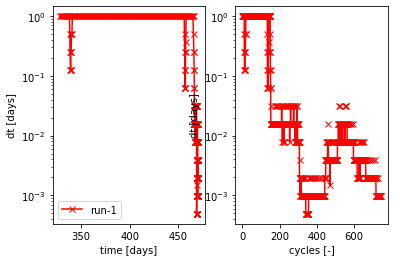

In [2]:
def plot_ts_history(dirname):
    fig, axs = plot_timestep_history.get_axs()
    with open(os.path.join(dirname, 'out.log'), 'r') as fid:
        data = plot_timestep_history.parse_logfile(fid)
    plot_timestep_history.plot(data,axs,'r','run-1')
    plot_timestep_history.decorate_axs(axs)
    return axs
    
plot_ts_history('run-1')
plt.show()

### Run example 1b

Restart from a checkpoint file by adding the line "restart from checkpoint file" to the "cycle driver" list, pointing to a checkpoint file that is closest to the problematic time (Cycle ~300).  This makes it faster to debug, because we don't have to start each run from the beginning.

    cd ../run-1b
    ats ../priestley_taylor-1b.xml &> out-new.log
    
Again, plot the timestep history, and zoom in to find a "bad" cycle that fails.

    python ${ATS_SRC_DIR}/tools/utils/plot_timestep_history.py -o out.log

Zoom in until we can find a specific timestep that is failing -- Cycle 307 looks promising.

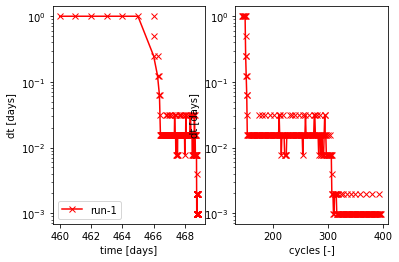

In [3]:
# first plot, just the basic timestep history plot.  Note it starts at the restarted time, ~day 460
axs = plot_ts_history('run-1b')
plt.show()

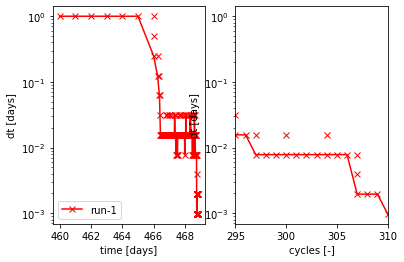

In [4]:
# second plot -- zoom in around Cycle 300 when it looks like the timestep is failing
axs = plot_ts_history('run-1b')
axs[1].set_xlim([295,310])
plt.show()


Inspect the error on one of the failing tries at Cycle 307.  What cell is struggling?  (See powerpoint slide.)

    less run-1b/out.log  # Search for "Cycle = 307"
    

Inspection suggests that cells 0 and 1314 might be part of the problem.


### Run example 1c

Add one or more of these cells as debug cells by adding the following entry to the Richards PK list:

    <Parameter name="debug cells" type="Array(int)" value="{1314}"/>
    
Rerun through Cycle 307 with "high" verbosity to see the debugging information about cells 0 and 1314.

    cd ../run-1c
    ats --verbosity=high ../priestley_taylor-1c.xml &> out-new.log
    
Inspect the output at Cycle 307 -- what is happening?  Why is this bad?  Look at the saturation (noting the residual saturation of the water retention curve) and the source (which is due to transpiration).  (See powerpoint slide.)


### Plot the water retention curve and transpiration limiter

The fact that the cell contains only residual water, but the transpiration is still taking water, suggests that the transpiration downregulation is not working correctly.  Plot the water retention curve and the transpiration downregulation (the wilting point model):

    python $ATS_SRC_DIR/tools/utils/plot_wrm.py --wrm="1.e-4 3 0.1 wrm" --wp="350000 2550000 mywp"
    
Why is this bad?


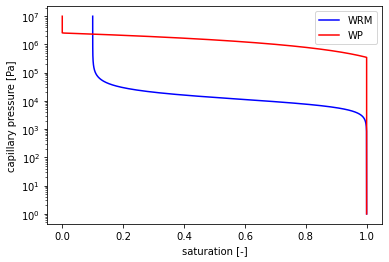

In [5]:
# plot of the Water Retention model and Wilting Point model.
wrm = plot_wrm.VanGenuchten(alpha=1.e-4, n=3, sr=0.1)
wp = plot_wrm.WiltingPointLimiter(350000,2550000)

def plot(wrm, wp):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    plot_wrm.plot(wrm, ax, 'b', label='WRM')
    plot_wrm.plot(wp, ax, 'r', label='WP')
    ax.legend()
    plt.show()
    
plot(wrm, wp)

Note the wilting point model, which controls how transpiration downregulates, turns off at much higher (more negative) capillary pressure.  Between 10^5 and 10^6 Pa, there is no water to give but the transpiration is still "on."

By changing the wilting point model parmeters, we can "turn off" transpiration when there is no water.

    python $ATS_SRC_DIR/tools/utils/plot_wrm.py --wrm="1.e-4 3 0.1 wrm" --wp="350000 2550000 mywp"


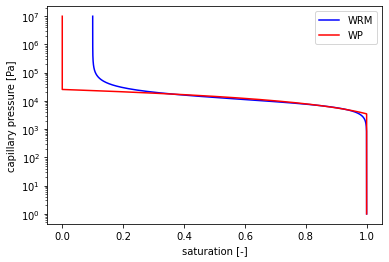

In [6]:
wp2 = plot_wrm.WiltingPointLimiter(3500,25500)
plot(wrm, wp2)

### Fix the run

Update the wilting point parameters by changing values:

    <Parameter name="mafic potential at fully closed stomata [Pa]" type="double" value="25500" />
    <Parameter name="mafic potential at fully open stomata [Pa]" type="double" value="3500" />
    
Then rerun the code:

    cd ../run-1d
    ats ../priestley_taylor-1d.xml &> out-new.log
    


## Bad Physics

Mistakes in the model are possible in ATS in ways that are not possible in many codes, due to the flexibility of the component-based design of ATS.

### Run Example 2

    cd ../run-2
    ats ../priestley_taylor-2.xml &> out.log
    
This run successfully completes, but is it "correct?"

* Yes, it did what you told it to do.
* No, it didn't do what you wanted it to do.

### Inspect the Mass Balance

Almost always a good idea to plot and understand a global mass conservation calculation:

    dTheta = dt * (sources - sinks)
    
Run the script, plot_mass_balance.py:

    python plot_mass_balance.py run-2
    
In this case, there are two independent water balances -- conservation of water in the surface and subsurface, and conservation of water in the snowpack.  These could be further split up by separating surface vs subsurface, but we often lump these two together.

    dQ_surf_subsurf = dt * (Prain + SM - Q - ET)
    dQ_snow = dt * (Psnow - SM)
    
    Prain = precipitation of rain
    Psnow = precipitation of snow
    SM = snow-melt
    Q = runoff / discharge
    ET = evapotranspiration
    
Observations for each of these are set up in the input file, integrated over the entire domain, along with observations for water content.  The included script, `plot_mass_balance.py` shows units conversions, integration in time, etc, as needed to show a mass balance calculation following these equations.


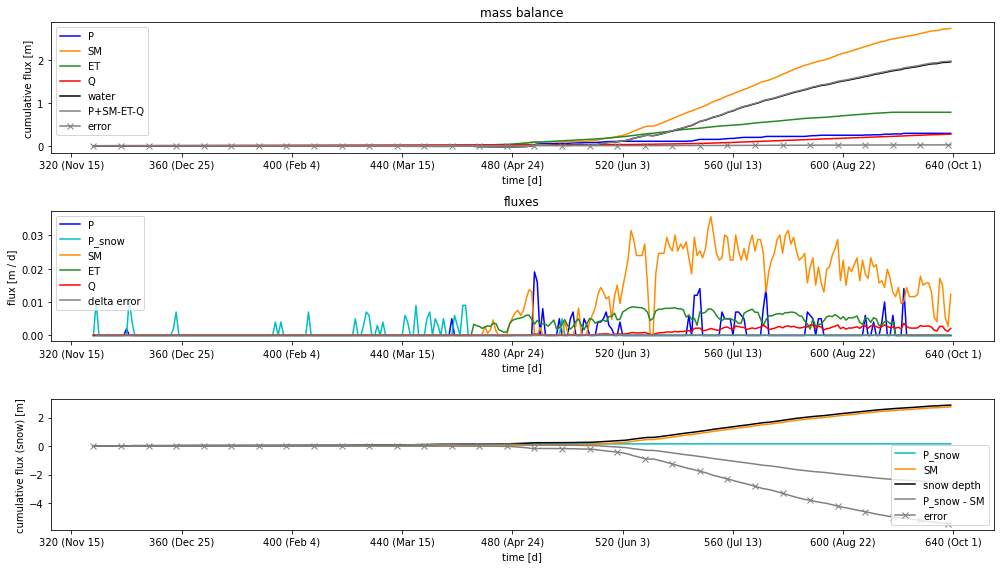

In [7]:

def plot_water(dirname):
    fig = plt.figure(figsize=(14,8))
    axs = fig.subplots(3,1)

    data = plot_mass_balance.load(dirname)
    plot_mass_balance.plot(data, dirname, '-', fig, axs)
    plt.tight_layout()
    plt.show()
    
plot_water('run-2')


Note the clear loss of mass in the snow balance -- large negative error.

Note also the large snowmelt -- bigger than the snowfall!

### Fix the problem

Inspection of the input file shows the error in the snow source term.  From `priestley_taylor-2.xml`:

    <ParameterList name="snow-source_mps" type="ParameterList">
      <Parameter name="field evaluator type" type="string" value="additive evaluator" />
      <Parameter name="evaluator dependencies" type="Array(string)" value="{snow-precipitation, snow-melt}" />
      <Parameter name="units" type="string" value="m s^-1" />
    </ParameterList>
    
The snow source should be `Psnow - SM`, not `Psnow + SM` as is specified here.  Correct the sign error:

    <ParameterList name="snow-source_mps" type="ParameterList">
      <Parameter name="field evaluator type" type="string" value="additive evaluator" />
      <Parameter name="evaluator dependencies" type="Array(string)" value="{snow-precipitation, snow-melt}" />
      <Parameter name="snow-melt coefficient" type="double" value="-1" />
      <Parameter name="units" type="string" value="m s^-1" />
    </ParameterList>


Rerun the problem with the changes in the input file (this is the same as `run-1d` above) and plot the correct balance.
      
      

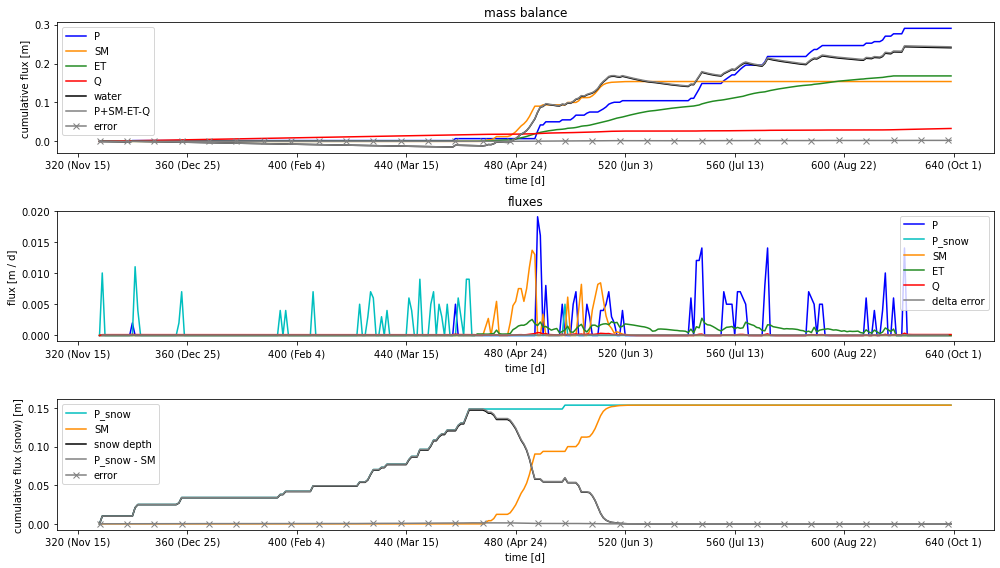

In [8]:
plot_water('run-1d')

Note that error is zero in both the surface and subsurface, and generally the terms make sense physically.